# Twitter Sentiment Analysis

First attempt at the Kaggle competition located at:
https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

First, we will retrieve the training and testing data sets. Then we will inspect the data to see how it is organized and determine how we want to organize it for the applications that we are using.

In [2]:
# retrieve training data
with open("twitter_training.csv", "r") as file:
    content = file.read()
    lines = content.splitlines()

print("Training data preview:")
for i in range(10):
    print(lines[i], "\n")

# retrieve testing data
with open("twitter_validation.csv", "r") as file:
    content = file.read()
    lines = content.splitlines()

print("Testing data preview:")
for i in range(10):
    print(lines[i], "\n")

Training data preview:
2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ," 

2401,Borderlands,Positive,"I am coming to the borders and I will kill you all," 

2401,Borderlands,Positive,"im getting on borderlands and i will kill you all," 

2401,Borderlands,Positive,"im coming on borderlands and i will murder you all," 

2401,Borderlands,Positive,"im getting on borderlands 2 and i will murder you me all," 

2401,Borderlands,Positive,"im getting into borderlands and i can murder you all," 

2402,Borderlands,Positive,So I spent a few hours making something for fun. . . If you don't know I am a HUGE @Borderlands fan and Maya is one of my favorite characters. So I decided to make myself a wallpaper for my PC. . Here is the original image versus the creation I made :) Enjoy! pic.twitter.com/mLsI5wf9Jg 

2402,Borderlands,Positive,"So I spent a couple of hours doing something for fun... If you don't know that I'm a huge @ Borderlands fan and Maya is one of my favo

So we see that entries are assigned a number (which we may call a tweet ID), a subject, a sentiment label, and the text of the tweet. So let's clean up the data. It looks like there are several tweets that have very similar entries, so let's remove all but one of these types of tweets. We will organize the data into dictionaries with the keys 'Subject', 'Sentiment', and 'Tweet'. We will keep track of tweet ID numbers, and if a tweet has a tweet ID that has already been used, we will remove it. We will also label encode the sentiment values to prepare for model training. The labels will correspond to the following values: 'Neutral' as 0, 'Positive' as 1, 'Negative' as 2, and 'Irrelevant' as 3. If any of the data points have missing fields, we do not add them to the datasets.

In [3]:
# retrieve training data
with open("twitter_training.csv", "r") as file:
    content = file.read()
    lines = content.splitlines()
print("Number of tweets in raw data:", len(lines))
    
# organize data into a dictionary
train = {'subject': [], 'label': [], 'text': []}
# keep track of tweet IDs
tweetID = set()
for tweet in lines:
    # split at commas, but ignore commas in the tweet content
    values = tweet.split(',', 3)
    # don't add data with missing fields
    if len(values) < 4:
        continue
    # don't add tweet if duplicate
    if values[0] in tweetID:
        continue
    tweetID.add(values[0])

    
    train['subject'].append(values[1])
    # encode 'Neutral' as 0
    if values[2] == 'Neutral':
        values[2] = 0
    # encode 'Positive' as 1
    if values[2] == 'Positive':
        values[2] = 1
    # encode 'Negative' as 2
    if values[2] == 'Negative':
        values[2] = 2
    # encode 'Irrelevant' as 3
    if values[2] == 'Irrelevant':
        values[2] = 3
    train['label'].append(values[2])
    train['text'].append(values[3])
print("Number of tweets in resultant training data set:", len(train['subject']))

Number of tweets in raw data: 74682
Number of tweets in resultant training data set: 12447


In [4]:
# retrieve testing data
with open("twitter_validation.csv", "r") as file:
    content = file.read()
    lines = content.splitlines()

# organize data into a dictionary
test = {'subject': [], 'label': [], 'text': []}
for tweet in lines:
    # split at commas, but ignore commas in the tweet content
    values = tweet.split(',', 3)
    # don't add data with missing fields
    if len(values) < 4:
        continue
    
    test['subject'].append(values[1])
    # encode 'Neutral' as 0
    if values[2] == 'Neutral':
        values[2] = 0
    # encode 'Positive' as 1
    if values[2] == 'Positive':
        values[2] = 1
    # encode 'Negative' as 2
    if values[2] == 'Negative':
        values[2] = 2
    # encode 'Irrelevant' as 3
    if values[2] == 'Irrelevant':
        values[2] = 3
    test['label'].append(values[2])
    test['text'].append(values[3])

Check categories of 'Sentiment' for both data sets to ensure that no abnormal values exist.

In [5]:
sentimentTypes = set()
for i in range(len(train['label'])):
    sentimentTypes.add(train['label'][i])
print("Sentiment types in training data set:", sentimentTypes)

sentimentTypes = set()
for i in range(len(test['label'])):
    sentimentTypes.add(test['label'][i])
print("Sentiment types in testing data set:", sentimentTypes)

Sentiment types in training data set: {0, 1, 2, 3}
Sentiment types in testing data set: {0, 1, 2, 3}


Check categories of 'Subject' for both data sets. Ensure each subject appears in both data sets.

In [6]:
subjectTypes = set()
for i in range(len(train['subject'])):
    subjectTypes.add(train['subject'][i])
print("Subject types in training data set:", subjectTypes, "\n")

subjectTypes = set()
for i in range(len(test['subject'])):
    subjectTypes.add(test['subject'][i])
print("Subject types in testing data set:", subjectTypes, "\n")

for sub in subjectTypes:
    if sub not in train['subject'] or sub not in test['subject']:
        print(sub, "not in both data sets.")

Subject types in training data set: {'MaddenNFL', 'Overwatch', 'NBA2K', 'Battlefield', 'Dota2', 'PlayerUnknownsBattlegrounds(PUBG)', 'AssassinsCreed', 'Amazon', 'Borderlands', 'Xbox(Xseries)', 'TomClancysRainbowSix', 'FIFA', 'Fortnite', 'WorldOfCraft', 'Microsoft', 'GrandTheftAuto(GTA)', 'RedDeadRedemption(RDR)', 'Verizon', 'Cyberpunk2077', 'Facebook', 'CallOfDuty', 'johnson&johnson', 'LeagueOfLegends', 'TomClancysGhostRecon', 'Nvidia', 'HomeDepot', 'CallOfDutyBlackopsColdWar', 'ApexLegends', 'CS-GO', 'Google', 'Hearthstone', 'PlayStation5(PS5)'} 

Subject types in testing data set: {'MaddenNFL', 'Overwatch', 'NBA2K', 'Battlefield', 'Dota2', 'PlayerUnknownsBattlegrounds(PUBG)', 'AssassinsCreed', 'Amazon', 'Borderlands', 'Xbox(Xseries)', 'TomClancysRainbowSix', 'FIFA', 'Fortnite', 'GrandTheftAuto(GTA)', 'Microsoft', 'WorldOfCraft', 'RedDeadRedemption(RDR)', 'Verizon', 'Cyberpunk2077', 'Facebook', 'CallOfDuty', 'johnson&johnson', 'LeagueOfLegends', 'TomClancysGhostRecon', 'Nvidia', 'Home

Convert the datasets into Pandas dataframes and show a preview.

In [7]:
# convert the data sets to Pandas dataframes
train = pd.DataFrame(train)
test = pd.DataFrame(test)

# show the first tweet for each sentiment
display(train[train['label'] == 0].head())
display(train[train['label'] == 1].head())
display(train[train['label'] == 2].head())
display(train[train['label'] == 3].head())

,subject,label,text
2,Borderlands,0,"""Rock-Hard La Varlope, RARE & POWERFUL, HANDSO..."
7,Borderlands,0,Check out this epic streamer!.
8,Borderlands,0,Blaming Sight for Tardiness! A little bit of b...
10,Borderlands,0,. . [
13,Borderlands,0,"""One of our own @ProfZeroo is live w/ @borderl..."


,subject,label,text
0,Borderlands,1,"""im getting on borderlands and i will murder y..."
1,Borderlands,1,So I spent a few hours making something for fu...
3,Borderlands,1,that was the first borderlands session in a lo...
5,Borderlands,1,WE FINISHED BORDERLANDS 3 FINALLY YAS! Thank y...
11,Borderlands,1,Going to finish up Borderlands 2 today. I've g...


,subject,label,text
4,Borderlands,2,the biggest dissappoinment in my life came out...
6,Borderlands,2,Man Gearbox really needs to fix this dissapoin...
9,Borderlands,2,why does like every man in borderlands have sl...
16,Borderlands,2,Grounded almost looked pretty cool even despit...
18,Borderlands,2,@Borderlands how do I submit a complaint? Your...


,subject,label,text
17,Borderlands,3,"""Appreciate the (sonic) concepts / praxis Vale..."
21,Borderlands,3,Loving these new @GhostLifestyle cans!! Anyone...
23,Borderlands,3,How the hell are we into Halloween month alrea...
37,Borderlands,3,"""I'm in this @CBP video. @DHS_Wolf deceptively..."
44,Borderlands,3,4 favorite games of all time. (thanks @317Slay...


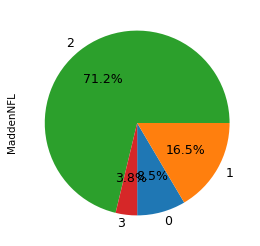

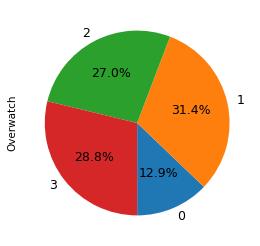

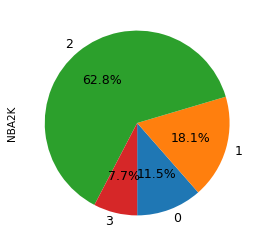

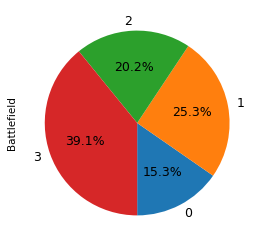

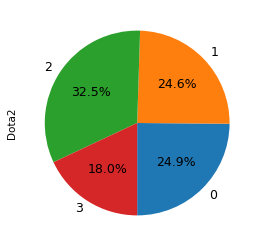

In [8]:
# visualize sentiments by subject (from training data set)
count = 0
for sub in subjectTypes:
    # count the number of tweets by sentiments
    sentiment_counts = train[train['subject']==sub].groupby(['label']).size()

    # make a pie chart
    fig = plt.figure(figsize=(4,4), dpi=75)
    ax = plt.subplot(111)
    sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label=sub)

    # limit to 5 pie charts
    count += 1
    if count == 5:
        break

We can see that there is a lot of variation in sentiments between subjects. Now we will tokenize the text to prepare it for the model training and testing.

In [9]:
from transformers import AutoTokenizer
import pyarrow as pa
from datasets import Dataset
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(text_data):
   return tokenizer(text_data['text'], truncation=True, padding=True)

tokenized_train = Dataset(pa.Table.from_pandas(train)).map(preprocess_function, batched=True)
tokenized_test = Dataset(pa.Table.from_pandas(test)).map(preprocess_function, batched=True)

Map:   0%|          | 0/12447 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

To optimize the training time, we will use a data collator to convert the training data to PyTorch tensors and concatenate them with the appropriate padding. We will also establish DistilBERT as the machine learning model because it is a smaller and faster version of the NLP model BERT. We need to make sure that it is trained to predict the appropriate number of labels.

In [10]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Build the trainer object.

In [11]:
from transformers import TrainingArguments, Trainer
 
repo_name = "finetuning-sentiment-model-twitter-data"
 
training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy='epoch',
   push_to_hub=False,
)

trainer = Trainer(
       model=model,
       args=training_args,
       train_dataset=tokenized_train,
       processing_class=tokenizer,
       data_collator=data_collator,
)

Execute training with the entire training data set of 12447 tweets.

In [12]:
trainer.train()

Step,Training Loss
500,1.098600
1000,0.914200
1500,0.832800


TrainOutput(global_step=1556, training_loss=0.9423443198510492, metrics={'train_runtime': 576.3402, 'train_samples_per_second': 43.193, 'train_steps_per_second': 2.7, 'total_flos': 854371973982072.0, 'train_loss': 0.9423443198510492, 'epoch': 2.0})

Now let's make predictions on the tokenized test data set. Then we will inspect the predictions object that was created.

In [13]:
# create predictions for each tweet in the testing data set
predictions = trainer.predict(tokenized_test)

In [14]:
predictions.predictions

array([[ 0.57203346, -1.4853753 , -0.7875915 ,  1.4867625 ],
       [ 2.602408  , -1.3662411 , -0.6814147 , -0.56129557],
       [-0.8503249 , -0.98526466,  2.8706765 , -1.497078  ],
       ...,
       [-0.32824287,  1.7873743 , -0.7743568 , -1.0367094 ],
       [-0.0779582 ,  1.4614048 , -0.39883527, -1.3059323 ],
       [ 2.5657485 , -0.9448805 , -0.6306575 , -0.9921087 ]],
      dtype=float32)

The predictions are given as lists of likelihoods, where the index of the list corresponds to the encoded label. The index of the highest likelihood is the prediction, so we will extract them from the predictions array and compare them to the actual labels.

In [15]:
preds = np.argmax(predictions.predictions, axis=-1)

In [16]:
n = len(test['label'])
correct = 0
for i in range(n):
    if test['label'][i] == preds[i]:
        correct += 1
print((correct / n)*100, "% accuracy")

71.3 % accuracy


So we see that the model predicted the sentiment of the testing data set with 71% accuracy. This is good performance for a lite version large language model. We may be able to change some parameters to get a higher accuracy. Let's look at the categories. The sentiments 'Irrelevant' and 'Neutral' are actually quite similar. Maybe if we combine the categories, it will increase our accuracy, since there are probably quite a few tweets mislabeled as 'Irrelevant' instead of 'Neutral' and vice versa. Let's begin by reading in the data again and redefining the label encoding.

In [17]:
# retrieve training data
with open("twitter_training.csv", "r") as file:
    content = file.read()
    lines = content.splitlines()
print("Number of tweets in raw data:", len(lines))
    
# organize data into a dictionary
train = {'subject': [], 'label': [], 'text': []}
# keep track of tweet IDs
tweetID = set()
for tweet in lines:
    # split at commas, but ignore commas in the tweet content
    values = tweet.split(',', 3)
    # don't add data with missing fields
    if len(values) < 4:
        continue
    # don't add tweet if duplicate
    if values[0] in tweetID:
        continue
    tweetID.add(values[0])

    
    train['subject'].append(values[1])
    # encode 'Irrelevant' or 'Neutral' as 0
    if values[2] == 'Irrelevant' or values[2] == 'Neutral':
        values[2] = 0
    # encode 'Positive' as 1
    if values[2] == 'Positive':
        values[2] = 1
    # encode 'Negative' as 2
    if values[2] == 'Negative':
        values[2] = 2
    train['label'].append(values[2])
    train['text'].append(values[3])
print("Number of tweets in resultant training data set:", len(train['subject']))


# retrieve testing data
with open("twitter_validation.csv", "r") as file:
    content = file.read()
    lines = content.splitlines()

# organize data into a dictionary
test = {'subject': [], 'label': [], 'text': []}
for tweet in lines:
    # split at commas, but ignore commas in the tweet content
    values = tweet.split(',', 3)
    # don't add data with missing fields
    if len(values) < 4:
        continue
    
    test['subject'].append(values[1])
    # encode 'Irrelevant' or 'Neutral' as 0
    if values[2] == 'Irrelevant' or values[2] == 'Neutral':
        values[2] = 0
    # encode 'Positive' as 1
    if values[2] == 'Positive':
        values[2] = 1
    # encode 'Negative' as 2
    if values[2] == 'Negative':
        values[2] = 2
    test['label'].append(values[2])
    test['text'].append(values[3])

Number of tweets in raw data: 74682
Number of tweets in resultant training data set: 12447


Now let's make sure we only have three categories.

In [18]:
sentimentTypes = set()
for i in range(len(train['label'])):
    sentimentTypes.add(train['label'][i])
print("Sentiment types in training data set:", sentimentTypes)

sentimentTypes = set()
for i in range(len(test['label'])):
    sentimentTypes.add(test['label'][i])
print("Sentiment types in testing data set:", sentimentTypes)

Sentiment types in training data set: {0, 1, 2}
Sentiment types in testing data set: {0, 1, 2}


Now we tokenized the data sets with redefined labels.

In [19]:
from transformers import AutoTokenizer
import pyarrow as pa
from datasets import Dataset
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(text_data):
   return tokenizer(text_data['text'], truncation=True, padding=True)

# convert the data sets to Pandas dataframes
train = pd.DataFrame(train)
test = pd.DataFrame(test)
# tokenize the data sets
tokenized_train = Dataset(pa.Table.from_pandas(train)).map(preprocess_function, batched=True)
tokenized_test = Dataset(pa.Table.from_pandas(test)).map(preprocess_function, batched=True)

Map:   0%|          | 0/12447 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

We need to take care to redefine the number of labels in the model.

In [20]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Since we changed a few variables, we need to reinitialize the trainer object.

In [21]:
trainer = Trainer(
       model=model,
       args=training_args,
       train_dataset=tokenized_train,
       processing_class=tokenizer,
       data_collator=data_collator,
)

Now we re-train the model and evaluate its accuracy.

In [22]:
trainer.train()

Step,Training Loss
500,0.840000
1000,0.688700
1500,0.614000


TrainOutput(global_step=1556, training_loss=0.7086189412212617, metrics={'train_runtime': 575.2649, 'train_samples_per_second': 43.274, 'train_steps_per_second': 2.705, 'total_flos': 854356738014234.0, 'train_loss': 0.7086189412212617, 'epoch': 2.0})

In [23]:
# create predictions for each tweet in the testing data set
predictions = trainer.predict(tokenized_test)
# extract predictions from outputs
preds = np.argmax(predictions.predictions, axis=-1)
# evaluate accuracy
n = len(test['label'])
correct = 0
for i in range(n):
    if test['label'][i] == preds[i]:
        correct += 1
print((correct / n)*100, "% accuracy")

77.8 % accuracy


The model is now 77.8% accurate, which shows good improvement.